<a href="https://colab.research.google.com/github/vsojo/covid19/blob/master/Covid19_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![American Museum of Natural History](https://raw.githubusercontent.com/vsojo/covid19/master/_img/AMNH_Logo_128x128.png)

# A simple agent-based network model of SARS-CoV-2 spread
**[ This model is under construction, please stay tuned, or [contact us](mailto:vsojo@amnh.org) to collaborate! ]**

(if you are seeing this on GitHub, you may want to click on the link above to "Open in Colab". Please read along for further details)

## Technical foreword: Running the model
This model is a Jupyter Notebook developed in Google Colab. If you are seeing it anywhere else (e.g. GitHub), you may want to consider [opening it in Colab](https://colab.research.google.com/github/vsojo/covid19/blob/master/Covid19_model.ipynb).

You can browse the model and some output just like you would a passive website. But you can also change parameters and run it yourself. To run the model once you're in Colab, you will need to log in with a Google-enabled account (apologies for that limitation). Then you will need to click **Runtime > Run all** in the menu at the top left.

You will be given a warning that Google did not develop this code (because they didn't – [we](#contributors) did). You will need to accept this warning if you wish to run the code. Otherwise you should still be able to browse this document, but you will not be able to change or execute the code beyond that.

Alternatively, if you are familiar Jupyter Notebooks, you can freely download this document (which contains the whole model) from either Colab or GitHub, but you may need to modify a few Google-specific bits (chiefly Google Widgets, which may not run on normal Jupyter).

## Controling the parameters
You can alter any parameters that you decide in the dashboards below. All the code is included within this document itself, so you can essentially alter everything in your own copy of the code. However, the code is generally hidden. Wherever there is hidden code, e.g. in the dashboards, **you can double click on the dashboard to edit its code**. You can then double-click again to hide the code, or use **Edit > Show/hide code** in the main menu at the top.

**Note:** if you wish to alter the code here, you will need to copy this document to your own Google Drive and save it there, then you should be able to change your copy at will. Please feel free to modify anything you wish, you won't affect our original code. If you come up with any suggestions for improvement or want to collaborate, we would very much welcome it if you [contact us](mailto:vsojo@amnh.org). If you are familiar with GitHub, you can also share your suggestions with us there.

# Introduction
This model seeks to minimally reproduce the behaviour of a system in which there are people living in cities, and there is an infection meant to mimic the 2020 Covid-19 crisis. People meet other people and get infected or pass on their infections. They also recover, or they can get worse and require hospitalisation, or even a ventilator. People may also die. Existing health pre-conditions and the unavailability of hospital beds/ventilators increase the risk of becoming worse and of dying.

Ultimately, **the objective of the model is to allow customisation in the study of the epidemiological behaviour of a pandemic, as well as the effects of different social measures**, such as what happens when people self-isolate, when travel to other cities (which may have their own infections going on) is restricted or allowed again, or local lockdowns are imposed that restrict how many people each person meets every day.

This model is (constantly) under development. A list of [contributors](#contributors) is presented at the end of this document. If you have any suggestions for improvement or would like to collaborate, please leave your comments on Colab, on GitHub, or via email at vsojo@amnh.org

In [0]:
#@title Libraries, imports [double click here to show/hide code]
#################
#   LIBRARIES   #
#################
import ipywidgets
from IPython.display import display
from google.colab import widgets as gwidgets
import math
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import random
from scipy.stats import poisson
from collections import defaultdict

In [0]:
#@title Helper functions [double click here to show/hide code]

##############################
#  RANDOM-NUMBER GENERATION  #
##############################
N_RANDS = 100
def get_rand():
    """Returns a random number between 0 and 1"""
    if len(rands) == 0:
        # fill up the list of random numbers if it's empty
        rands.extend(np.random.rand(N_RANDS))
    return rands.pop()
# end def: get_rand()

In [0]:
#@title Constants [double click here to show/hide code]

###################
#  PERSON - HEALTH STATUS  #
###################
HEALTHY = 1
ILL = 2
VERY_ILL = 3
CRITICAL = 4

#######################################
#  INFECTION - SUSCEPTIBILITY STATUS  #
#######################################
SUSCEPTIBLE   = 0 # can catch a disease
LATENT        = 1 # equivalent to "exposed" in a typical SEIR model. Using "latent" here because "exposed" can be ambiguous.
INFECTIOUS    = 2 # actively contagious at present
IMMUNE        = 3 # equivalent to "recovered" in a typical SEIR model. Using "immune" here because "recovered" can be ambiguous when considering symptoms
RESUSCEPTIBLE = 4 # In case the infection can be reacquired, but at a lower/different susceptibility, otherwise SUSCEPTIBLE can be used

################################
#  INFECTION - SYMPTOM STATUS  #
################################
ASYMPTOMATIC  = 0
MILD          = 1
SEVERE        = 2

# Description of the model
This is an individual-based or agent-based model. That means that the model tracks the health and behaviours of each person individually, and the events in each city one by one.
There are four (4) main types of entity (or "objects") in this model: **Person**, **City**, **Disease**, and **Infection**. 
+ Objects of the **`Person`** class have properties such as age, health status, whether or not they are infected, and more. At each iteration, they can go out, meet other people, get infected, their health can get better or worse, they can travel to other cities, and more.
+ Objects of the **`City`** class contain objects of the Person class. Cities can take actions such as impose lockdown, cancel travel to other cities, and so on. Cities also have intrinsic qualities such as how social people are, what population distribution (pyramid) the ages of its citizens follow, and more. In a minimal case, the model may have only one city.
+ Objects of the **`Disease`** class contain specifications about epidemiological and biological factors, such as duration of symptoms, infectivity per contact, and more. In the basic version of the model there is only one Disease.
+ Objects of the **`Infection`** class are instances of a `Disease` when acquired by a `Person`, and contain details such as how long ago it was acquired, whether it is presently latent, contagious, immunised, or if the person is susceptible to it again.

These classes are described in further detail below. But first, we address (and write code for) age distributions.

# Age distribution
The ages of people in each city are sampled from a population pyramid.

You can choose from a few example pyramids that are pre-computed into the model, or you can enter details of your own **Custom** pyramid.

The pyramids are presently defined as symmetric by sex (i.e. there are no differences between the distributions of men and women). You can explore the types in the following tabs, and then choose your desired type below.

**Note:** The pyramids are presented as probability density functions of being a certain age.

In [4]:
#@title Custom pyramid [double-click here to show/hide code]
print("If desired, please enter either population numbers, percentages,\nor proportions for a custom population pyramid.")
grid = gwidgets.Grid(7, 3)

raw_ages = ['0-4', '5-9', '10-14', '15-19', '20-24', '25-29', '30-34', '35-39', '40-44', '45-49', '50-54', '55-59', '60-64', '65-69', '70-74', '75-79', '80-84', '85-89', '90-94', '95-99', '100+']
age_pairs = [age.replace('-', '_') for age in raw_ages]
age_pairs[-1] = age_pairs[-1].replace('+', "_")
age_freqs = [2419114, 2742065, 2653148, 2478474, 2162329, 2130779, 2125051, 1987068, 1862545, 1688822, 1582057, 1382558, 1131313, 823993, 576310, 370146, 218816, 114862, 48126, 15534, 2718]

float_choosers = {}
float_chooser_indices = []
for i, (row, col) in enumerate(grid):
  index = 'pop_' + age_pairs[i]
  float_choosers[index] = ipywidgets.FloatText(
    value=age_freqs[i],
    min=0,
    max=100000000,
    step=1,
    description=index,
    disabled=False
  )
  display(float_choosers[index])
  float_chooser_indices.append(index)
# end for

If desired, please enter either population numbers, percentages,
or proportions for a custom population pyramid.


,,
,,
,,
,,
,,
,,
,,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

FloatText(value=2419114.0, description='pop_0_4', step=1.0)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

FloatText(value=2742065.0, description='pop_5_9', step=1.0)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

FloatText(value=2653148.0, description='pop_10_14', step=1.0)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

FloatText(value=2478474.0, description='pop_15_19', step=1.0)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

FloatText(value=2162329.0, description='pop_20_24', step=1.0)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

FloatText(value=2130779.0, description='pop_25_29', step=1.0)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

FloatText(value=2125051.0, description='pop_30_34', step=1.0)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

FloatText(value=1987068.0, description='pop_35_39', step=1.0)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

FloatText(value=1862545.0, description='pop_40_44', step=1.0)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

FloatText(value=1688822.0, description='pop_45_49', step=1.0)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

FloatText(value=1582057.0, description='pop_50_54', step=1.0)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

FloatText(value=1382558.0, description='pop_55_59', step=1.0)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

FloatText(value=1131313.0, description='pop_60_64', step=1.0)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

FloatText(value=823993.0, description='pop_65_69', step=1.0)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

FloatText(value=576310.0, description='pop_70_74', step=1.0)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

FloatText(value=370146.0, description='pop_75_79', step=1.0)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

FloatText(value=218816.0, description='pop_80_84', step=1.0)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

FloatText(value=114862.0, description='pop_85_89', step=1.0)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

FloatText(value=48126.0, description='pop_90_94', step=1.0)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

FloatText(value=15534.0, description='pop_95_99', step=1.0)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

FloatText(value=2718.0, description='pop_100_', step=1.0)

<IPython.core.display.Javascript object>

If you wish to use the **Custom** pyramid, change the values above at will, then run the following box again.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

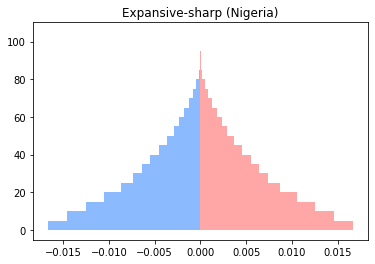

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

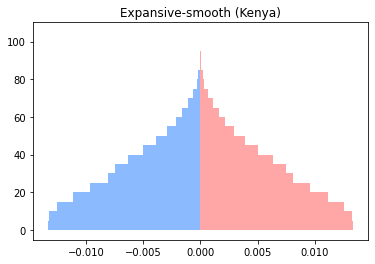

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

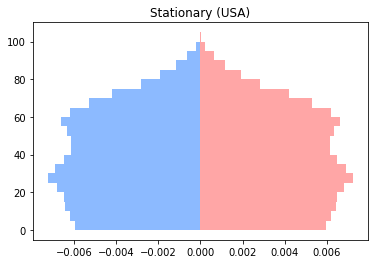

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

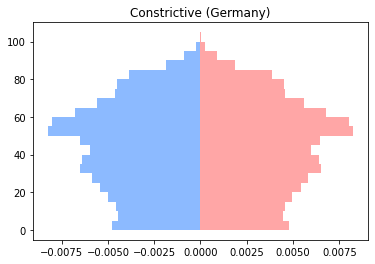

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

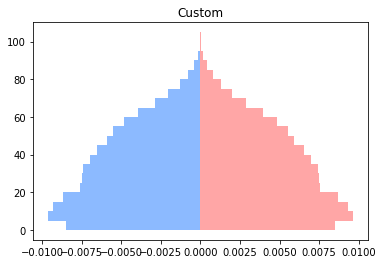

<IPython.core.display.Javascript object>

In [5]:
#@title Examples of population pyramid types [double-click here to show/hide code]
pyramids = [
   {'name':"Expansive-sharp (Nigeria)", 'csv_url':'https://raw.githubusercontent.com/vsojo/covid19/master/Population_Pyramids/Nigeria_pyramid_2019.csv'}
  ,{'name':"Expansive-smooth (Kenya)", 'csv_url':'https://raw.githubusercontent.com/vsojo/covid19/master/Population_Pyramids/Kenya_pyramid_2019.csv'}
  ,{'name':"Stationary (USA)", 'csv_url':'https://raw.githubusercontent.com/vsojo/covid19/master/Population_Pyramids/USA_pyramid_2019.csv'}
  ,{'name':"Constrictive (Germany)", 'csv_url':'https://raw.githubusercontent.com/vsojo/covid19/master/Population_Pyramids/Germany_pyramid_2019.csv'}
  ,{'name':"Custom"}
  # If you wish to add more pyramid styles, you should do so here.
  # You don't have to use Wikipedia's age bins, you can just use any set of bins you like
  # but be sure to specify them with the 'age_bins' parameter, as in the first one (which is only 
  # there as an example. In truth it's not necessary to specify the bins if you're following Wikipedia)
]

# Extract the names of the pyramids, which we will use a couple of times below
pyramid_names = [f"{i+1}. {pyramid['name']}" for i, pyramid in enumerate(pyramids)]

# Create a GoogleWidget TabBar with each of the Pyramid names 
pyr_tb = gwidgets.TabBar(pyramid_names)

AGE_BIN_SIZE = 5 # How many years in each age bin

for i, pyramid in enumerate(pyramids):
  if 'csv_url' in pyramid:
    # load the population CSV file from a URL into a pandas dataframe
    pyr_df = pd.read_csv(pyramid['csv_url'])
    # add men and women to have total population per age structure
    pyr_df['T'] = pyr_df['M'] + pyr_df['F']
  
    # just keep the raw list of age bins for the custom case
    raw_ages = list(pyr_df['Age'])
  else:
    # The custom pyramid needs to be handled separately
    pyr_df = pd.DataFrame(
      data={
         'Age': raw_ages
        ,'T': [float_choosers[index].value for index in float_chooser_indices]
      }
    )
  # end if: checking if this is the custom pyramid
  
  # sum all people to get the total population
  whole_population = sum(pyr_df['T'])
  
  # calculate the proportions for each age bin
  pyramid['age_bin_props'] = list(pyr_df['T']/whole_population)
  # Age bins are in the 'Age' column of the pyramid CSV file and thus the dataframe here.
  # They look something like "0-4", "5-9" and so on, except the last one which is just "100+".
  # So, we extract the age bins and parse them to integers using a nested list comprehension
  pyramid['age_bins'] = [[int(age) for age in age_bin.replace('+','').split('-')] for age_bin in pyr_df['Age']]
  # Make the second age of the last bin be whatever the top age is (100),
  # plus the size of the age bin... minus 1 because they are all made this way.
  pyramid['age_bins'][-1].append(pyramid['age_bins'][-1][0] + AGE_BIN_SIZE - 1)
  
  pyramid['p_cums'] = [] # the cumulative probabilities of being a certain age, to be used for random age assignment
  pyramid['p_raws'] = [] # the raw probabilities of being a certain age, year by year

  # We want to go over each age bin and check its proportion in the population.
  # As a simple starting point for the model, we just make all the five years
  # in that bin the same height, i.e. 1/AGE_BIN_SIZE (1/5th) of the proportion
  # of the whole five-year bin). It would be more elegant to alter each bin
  # with respect to the values of the preceding and following bins, but we take
  # the trivial solution for the time being.
  with pyr_tb.output_to(i):
    for j, age_bin_prop in enumerate(pyramid['age_bin_props']):
      age_bin = pyramid['age_bins'][j]
      for year in range(age_bin[0], age_bin[1]+1):
        # The proportion per year is 1/AGE_BIN_SIZE of that of the whole bin
        p_year = age_bin_prop/AGE_BIN_SIZE
        # Add this year's probability as a cumulative probability
        if len(pyramid['p_cums']):
          pyramid['p_cums'].append(pyramid['p_cums'][-1] + p_year)
        else: # it's the first one, 0, so nothing to accumulate yet
          pyramid['p_cums'].append(p_year)
        # end if: is this the first year?
        pyramid['p_raws'].append(p_year)
        plt.fill_between([0,-p_year/2,-p_year/2,0], [year,year,year+1,year+1], facecolor=(0,.4,1), alpha=0.45)
        plt.fill_between([0, p_year/2, p_year/2,0], [year,year,year+1,year+1], facecolor='r', alpha=0.35)
      # end for: adding and plotting every bin
    # end for
    plt.title(pyramid['name'])
    plt.show()
  # end with: plotting this pyramid
# end for: going over each pyramid

Please note that, although the pyramid is drawn as males+females for illustration purposes, no sex differences have been implemented into the model at present.

In [24]:
#@title Select a pyramid type and population size for the city
#print("Population pyramid type")
w_c1_pyramid_type = ipywidgets.Dropdown(options=list(pyramid_names), description="Pyramid type")
# w_c1_population_size = ipywidgets.IntText(value=10000000, min=-3, description="Pop. size")
w_c1_population_size = ipywidgets.Dropdown(
    options=[(50,50), (100,100), (500,500), ('1,000',1000), ('2,000',2000), ('5,000',5000), ('10,000',10000), ('100,000',100000)],
    description='Popul. size:',
    value=2000
)
display(w_c1_pyramid_type, w_c1_population_size)

Dropdown(description='Pyramid type', options=('1. Expansive-sharp (Nigeria)', '2. Expansive-smooth (Kenya)', '…

Dropdown(description='Popul. size:', index=4, options=((50, 50), (100, 100), (500, 500), ('1,000', 1000), ('2,…

In [0]:
c1_pyramid = pyramids[int(w_c1_pyramid_type.value.split('.')[0]) - 1]
c1_population = w_c1_population_size.value

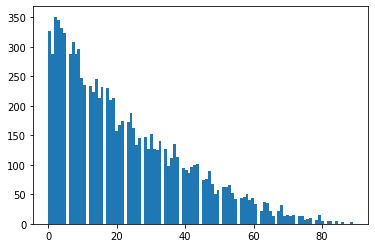

In [8]:
rands = np.random.random(c1_population)
#print(rands)
ages = np.digitize(rands, c1_pyramid['p_cums'])
plt.hist(ages, bins=len(c1_pyramid['p_cums']))
plt.show()

# The **Person** class
## Properties of a Person (_attributes_)
Persons have a number of properties, such as:
* Age (which has an inverse relation to the chance of surviving).
+ Whether or not they are infected.
+ Typical number of daily contacts (i.e. how many people they would meet on a given day on average. This number would change depending on the city's ordinances, whether the person is showing symptoms, has tested positive, or is hospitalised).
+ Health status (are they healthy, ill, very ill, or critical?).
+ Home City (which they have a high chance of returning to when they leave, in case there is more than one city in the model).
+ ...and more (see the description of the Person class below).

## Actions of a Person (_methods_)
* A person can die, regarless of whether or not they had the virus.
+ However, a person's chances of dying increase with:
    * Age.
    + Pre-existing conditions (these are described abstractly as an integer, with the default being zero - i.e. no pre-conditions. One pre-condition increases the chances of worsening and of dying, two increase it further, and so on.
    + Unavailability of a hospital bed or ventilator.
    + Infection status.
    + Health condition (higher is worse).

## Person class diagram
<table class="class_diagram">
    <tr>
        <th>Attributes of Person class</th>
    </tr>
    <tr class="attributes" title="Each Person has a unique identifier.">
        <td><code>+ id: int</code></td>
    </tr>
    <tr title="The age of the individual. Any individual can die. The older the individual, the more likely it is to die.">
        <td><code>- age: int</code></td>
    </tr>
    <tr title="Which City this Person comes from.">
        <td><code>- home_city: City</code></td>
    </tr>
    <tr title="Which City this Person currently is in.">
        <td><code>- current_city: City</code></td>
    </tr>
    <tr title="Has the individual been infected at some point?">
        <td><code>- has_been_infected: bool = False</code></td>
    </tr>    
    <tr title="How many days since the individual was infected. If -1, it hasn't been infected. 0 when just infected.">
        <td><code>- days_since_infection: int = -1</code></td>
    </tr>  
    <tr title="By default, an individual is not infected and therefore not infectious. This can change upon infection, and again upon recovery.">
        <td><code>+ is_infectious: bool = False</code></td>
    </tr>    
    <tr title="A person can have the virus without showing any symptoms, or show similar symptoms without having the virus. A person with symptoms reduces their social contacts.">
        <td><code>- has_symptoms: bool = False</code></td>
    </tr>
    <tr title="By default, an individual is vulnerable, unless it has been infected and recovered, or vaccinated effectively.">
        <td><code>- is_immune: bool = False</code></td>
    </tr>
    <tr title="HEALTHY=1, ILL=2 (tends to stay at home), VERY_ILL=3 (requires a hospital bed), CRITICAL=4 (requires a ventilator)">
        <td><code>- health_condition: int = HEALTHY</code></td>
    </tr>
    <tr title="The more preconditions a person has, the worse it is affected by infection.">
        <td><code>- n_preconditions: int = 0</code></td>
    </tr>
    <tr title="How many people does this person meet every day, if possible.">
        <td><code>- daily_contacts: int = 50</code></td>
    </tr>
    <!--
                  METHODS of the Person class    
    -->
    <tr style="border-top: 1px solid black">
        <th>Methods of Person class</th>
    </tr>
    <tr class="methods" title="the constructor of the class.">
        <td><code>- Person()</code></td>
    </tr>
    <tr title="Effectively, this works as the 'destructor' of the class. Any bed or ventilator is freed, the tally is increased. A death crisis may also be modelled, following reports from Ecuador, Italy and other places where funerary services have become overwhelmed.">
        <td><code>- die()</code></td>
    </tr>
    <tr>
        <td><code>- get_infected()</code></td>
    </tr>
    <tr>
        <td><code>- become_critical()</code></td>
    </tr>
    <tr title="">
        <td><code>- go_outside()</code></td>
    </tr>
    <tr>
        <td><code>+ meet_person(bool: is_person_infectious)</code></td>
    </tr>
    <tr title="In an early version of the model, this just sends Person to a migration blackbox, where they can get infected and from where they can come back. In a more complex version of the system, with multiple cities, the individual can visit other cities and get infected or bring an infection there.">
        <td><code>+ go_to_city(destination_city)</code></td>
    </tr>
</table>

In [0]:
#@title Code for the Person class [double-click here to show/hide code]
class Person:
  ###############
  # CONSTRUCTOR #
  ###############
  def __init__(self, **kwargs):
    # REQUIRED PARAMETERS THAT MUST BE PASSED IN UPON INSTANTIATION (CONSTRUCTION)
    required_params = {
      'home_city': "an object of class City",
      'age': "an integer, zero or higher",
      'n_preconditions': "an integer, zero or higher",
      'daily_contacts': "an integer, zero or higher"
    }
    if not all([param in kwargs for param in required_params]):
      joiner = "\n\t- "
      raise AttributeError("This Person needs to receive the following arguments upon creation:\n"
        + joiner + joiner.join(required_params))
    self._home_city = kwargs['home_city']
    self._age = kwargs['age']
    self._daily_contacts = kwargs['daily_contacts']
    self._n_preconditions = kwargs['n_preconditions'] if 'n_preconditions' in kwargs else 0
    
    # Other parameters that can be set upon instantiation
    self._current_city = kwargs['current_city'] if 'current_city' in kwargs else self._home_city

    self._DESIRED_MEETINGS = kwargs['DESIRED_MEETINGS'] if 'DESIRED_MEETINGS' in kwargs else 10
    self._remaining_meetings = None
    
    #  INFECTIONS  #
    # A list of all ongoing and previous Infections that this person has or has had
    self._infections = kwargs['infections'] if 'infections' in kwargs else []

    self._health_condition = kwargs['health_condition'] if 'health_condition' in kwargs else HEALTHY
    self._has_hospital_bed = kwargs['has_hospital_bed'] if 'has_hospital_bed' in kwargs else False
    self._has_ventilator = kwargs['has_ventilator'] if 'has_ventilator' in kwargs else False
    #self._ = kwargs[''] if '' in kwargs else 
    # RegEx to change list of attributes into kwargs extraction or default value:
    # SEARCH:[+-] ([\w]+): [\w]+ = (.*) REPLACE:self._\1 = kwargs['\1'] if '\1' in kwargs else \2
    
    # OTHER ATTRIBUTES TO SET UPON INITIALISATION
    
  # end def __init__: CONSTRUCTOR of the class

  def __str__(self):
    return f"This is Person #{id(self)}, aged {self.age()}, from City #{self.home_city().name()}"
  
  ##############
  # DESTRUCTOR #
  ##############
  def __del__(self):
    """This function is equivalent to death of the Person object.
    Upon destruction, a Person releases any bed or ventilator occupied.
    """
    if self._has_hospital_bed:
      self._current_city.release_hospital_bed()
    if self._has_ventilator:
      self._current_city.release_ventilator()

    # log the statistics of this person's death:
    #self._current_city.log_death(self)
  # end def __del__ : DESTRUCTOR of the class

  #########################
  # GETTER/SETTER METHODS #
  #########################
  def age(self, new_age=None):
    if new_age: self._age = new_age
    return self._age
  def home_city(self, new_home_city=None):
    if new_home_city: self._home_city = new_home_city
    return self._home_city
  def current_city(self, new_current_city=None):
    if new_current_city: self._current_city = new_current_city
    return self._current_city
  def health_condition(self, new_health_condition=None):
    if new_health_condition: self._health_condition = new_health_condition
    return self._health_condition
  def n_preconditions(self, new_n_preconditions=None):
    if new_n_preconditions: self._n_preconditions = new_n_preconditions
    return self._n_preconditions

  def has_symptoms(self, new_has_symptoms=None):
    if new_has_symptoms: self._has_symptoms = new_has_symptoms
    return self._has_symptoms  

  def infections(self, set__infections=None):
    if set__infections: self._infections = set__infections
    return self._infections
  
  def remaining_meetings(self, set__remaining_meetings=None):
    if set__remaining_meetings: self._remaining_meetings(set__remaining_meetings)
    return self._remaining_meetings
  # RegEx to create getter-setter method:
  # REPLACE:def \1(self, new_\1=None):\n  if new_\1: self._\1 = new_\1\n  else: return self._\1
  # END GETTER SETTER METHODS FOR THE PERSON CLASS

  #####################################
  # OTHER METHODS OF THE PERSON CLASS #
  #####################################
  def start_day(self):
    """
    Do anything that needs to be done at the start of a day,
    such as resetting the number of daily meetings, and
    increasing the Disease day counters.
    """
    # Desired meetings for this day
    self._remaining_meetings = self._DESIRED_MEETINGS

    # Diseases
    for infection in self._infections:
      infection.add_day()

      # Now check if the number of days that have passed mean
      # that the status needs to change
      # make INFECTIOUS if LATENT (i.e. exposed in traditional SEIR models) and passed necessary days, 
      if infection.status() == LATENT and infection.days_since_acquired() >= infection.disease().days_until_contagious():
        # set the Person's Infection status to INFECTIOUS
        infection.status(INFECTIOUS)
        # Change the status tracker
        self._current_city.person_status_changed(person=self, disease=infection.disease(), status_from=LATENT, status_to=INFECTIOUS)
      # if INFECTIOUS and passed necessary days, make IMMUNE
      elif infection.status() == INFECTIOUS and infection.days_since_acquired() >= infection.disease().days_until_not_contagious():
        infection.status(IMMUNE)
        self._current_city.person_status_changed(person=self, disease=infection.disease(), status_from=INFECTIOUS, status_to=IMMUNE)
      # if IMMUNE &and& can be reinfected &and& passed necessary days, make RESUSCEPTIBLE
      elif infection.status() == IMMUNE and infection.disease().days_until_resusceptible() > 0 and infection.days_since_acquired() >= infection.disease().days_until_resusceptible():
        self._status = RESUSCEPTIBLE
        self._current_city.person_status_changed(person=self, disease=infection.disease(), status_from=IMMUNE, status_to=RESUSCEPTIBLE)
      # end if: changing the infection status and updating the trackers in the current city
  # end def: start_day()

  def decrease_meetings(self, n=1):
    """Decreases the counter of meetings remaining for this Person by n."""
    self._remaining_meetings -= n
  # end def: decrease_meetings
  
  def get_infected(self, disease):
    """Adds an Infection of this Disease to this Person's list of Infections."""
    self._infections.append(Infection(disease=disease))
    # Also, tell the City to track this Person's new Infection with this Disease
    self.home_city().add_infected(self, disease)
  # end def: get_infected)

# The **City** Class
+ Persons live in a **City**, the second unit in the model (but initially there is only one city).
+ The city has a number of properties, such as:
    * How social people are (i.e. how many people each person is likely to meet each day, as a distribution around an average).
    + How many hospital beds and ventilators there are
    + How many of those beds and ventilators are currently available.
    + Optionally, which cities this city is connected to and how intensely (initially there is only one city and migration is dealt-with in an abstract manner, see below).
    + How many people emigrate from the city at any given iteration (by default, the number of people who migrate back in is the same, so that no people are lost by migration).
+ The City also has a number of actions it can perform (full list below), for example:
    * Whether tests are being performed (people who test positive are more likely to stay at home. If the model is networked, then the a percentage of the contacts of those people would be informed and their probability of meeting other people would also fall, if possibly by less than for the original tested person).
    + The city can do vaccinations.
    + The city can do serology tests to check who has had a disease.
+ There are a number of high-risk people in the city. These persons meet far many more people than regular people do. These correspond to e.g. health personnel, bus drivers, grocery store workers, immigration officers, bank tellers, and so on.
+ Although not necessary for the most minimal description of the model, there can be more than one city, and these cities would be connected to each other.
+ As a first approach, though, there is abstract emigration: some people just leave the city, but they may end up in a migration blackbox for "not-in-this-city". People in hospital cannot leave the city.
+ Similarly, other people can come into the city, and these new people would come with their own infectiousness and pre-existing conditions, assigned at random.

## City class diagram
<table class="class_diagram">
    <tr>
        <th>Attributes of the City class</th>
    </tr>
    <tr class="attributes" title="Each City has a unique identifier, which can be used to track connections to other cities, and by Persons to know where they are and where home is.">
        <td><code>+ id: int</code></td>
    </tr>
    <tr title="The list of all people living in this city.">
        <td><code>- people: array of <b>Person</b></code></td>
    </tr>
    <tr title="How many persons live in this city.">
        <td><code>- population: int = &Sigma;#Persons == len(people)</code></td>
    </tr>
    <tr title="How many hospital beds the city regularly has, for each 1 thousand citizens.">
        <td><code>- N_HOSP_BEDS_PER_1K: float = 2.0</code></td>
    </tr>
    <tr title="How many hospital beds the city regularly has, calculated from the number per 1 thousand citizens, above. In a time of crisis, the City may add more beds, and then it may remove those extra beds back down to this number once the crisis is subsiding.">
        <td><code>- N_HOSP_BEDS_ORIGINAL: int</code></td>
    </tr>
    <tr title="How many hospital beds are presently available.">
        <td><code>- n_hosp_beds_available: int</code></td>
    </tr>
    <tr title="How many hospital beds are presently in use.">
        <td><code>- n_hosp_beds_in_use: int</code></td>
    </tr>
    <tr title="How many ventilators the city regularly has, for each 100 thousand citizens.">
        <td><code>- N_VENTILATORS_PER_100K: float = 10.0</code></td>
    </tr>
    <tr title="How many ventilators the city regularly has, calculated from the number per 100 thousand citizens, above. In a time of crisis, the City may add more ventilators, and then it may remove those extra ventilators back down to this number once the crisis is subsiding. Optionally, the City may even go below this number and donate some of its ventilators to another city.">
        <td><code>- N_VENTILATORS_ORIGINAL: int</code></td>
    </tr>
    <tr title="How many ventilators are presently available.">
        <td><code>- n_ventilators_available: int</code></td>
    </tr>
    <tr title="How many ventilators are presently in use.">
        <td><code>- n_ventilators_in_use: int</code></td>
    </tr>
    <tr title="How many people does the average 'regular' Person in this City meet each day? This could be sampled e.g. from a Poisson distribution around this number. Note that there are also high-risk people who meet a lot of people each day, below.">
        <td><code>- group_size_regular: int = 30</code></td>
    </tr>
    <tr title="What proportion of the population are high-contact (e.g. health personnel, public-transport drivers, ?">
        <td><code>- p_high_contact: int = 0.05 (5%)</code></td>
    </tr>
    <tr title="How many people does the average 'high-contact' Person in this City meet each day? This could be sampled e.g. from a Poisson distribution around this number. Note that there are also 'regular' people who meet much fewer people each day, above.">
        <td><code>- group_size_high_contact: int = 500</code></td>
    </tr>
    <tr title="How many comorbidities the average person is born with in this City, sampled from a Poisson distribution. Further comorbidities are added the older the person.">
        <td><code>- birth_comorbidities_poisson_lambda: float = 1.0</code></td>
    </tr>
    <tr title="Which cities is this city connected to?">
        <td><code>- cities_network: keyval</code></td>
    </tr>
    <tr title="What proportion of the population migrate to another city each day on average?">
        <td><code>- p_migration: int = 0.10 (10%)</code></td>
    </tr>
    <!--
                  METHODS of the City class    
    -->
    <tr>
        <th>Methods of the City class</th>
    </tr>
    <tr title="In a time of crisis, the City may add more beds, and then it may remove those extra beds back down to the original number once the crisis is subsiding.">
        <td><code>- add_hosp_beds(int n_new_beds)</code></td>
    </tr>
    <tr title="Must first check if there aren't people in those beds.">
        <td><code>- remove_hosp_beds(int n_beds_to_remove)</code></td>
    </tr>
    <tr title="In a time of crisis, the City may add more ventilators, and then it may remove those extra ventilators back down to the original number once the crisis is subsiding.">
        <td><code>- add_ventilators(int n_ventilators_to_add)</code></td>
    </tr>
    <tr title="Must first check if there aren't people using those ventilators.">
        <td><code>- remove_ventilators(int n_ventilators_to_remove)</code></td>
    </tr>
    <tr title="Must first check that there aren't people using those ventilators, and that there are enough to donate.">
        <td><code>- donate_ventilators(recipient_city, how_many)</code></td>
    </tr>
    <tr title="This City can ask for ventilators, in the hope that some other City will have and donate them.">
        <td><code>- ask_for_ventilators(how_many)</code></td>
    </tr>
</table>

In [0]:
#@title Code for the City class [double-click here to show/hide code]
class City:
  def __init__(self, **kwargs):
    # PARAMETERS SENT INTO THE CLASS UPON CONSTRUCTION
    self._name = kwargs['name'] if 'name' in kwargs else id(self)
    self._population = kwargs['population'] if 'population' in kwargs else 100
    self._pop_pyramid = kwargs['pop_pyramid'] if 'pop_pyramid' in kwargs else c1_pyramid
    # Daily meetings (regular vs. high-contact Persons)
    self._n_meetings_regular = kwargs['group_size_regular'] if 'group_size_regular' in kwargs else w_n_meetings_regular.value
    self._n_meetings_high_contact = kwargs['group_size_regular'] if 'group_size_regular' in kwargs else w_n_meetings_high_contact.value
    self._p_high_contact = kwargs['p_high_contact'] if 'p_high_contact' in kwargs else w_p_high_contact.value
    
    self._n_preconditions_at_birth = kwargs['n_preconditions_at_birth'] if 'n_preconditions_at_birth' in kwargs else w_n_preconditions_at_birth.value
    self._cities_network = kwargs['cities_network'] if 'cities_network' in kwargs else {}
    self._p_migration = kwargs['p_migration'] if 'p_migration' in kwargs else 0.1
    self._in_lockdown_foreigners = kwargs['in_lockdown_foreigners'] if 'in_lockdown_foreigners' in kwargs else False
    self._in_lockdown_all = kwargs['in_lockdown_all'] if 'in_lockdown_all' in kwargs else False
    # HOSPITAL DATA
    self._N_HOSP_BEDS_PER_1K = kwargs['N_HOSP_BEDS_PER_1K'] if 'N_HOSP_BEDS_PER_1K' in kwargs else 2.0
    self._N_HOSP_BEDS_ORIGINAL = kwargs['N_HOSP_BEDS_ORIGINAL'] if 'N_HOSP_BEDS_ORIGINAL' in kwargs else math.ceil(self._population * self._N_HOSP_BEDS_PER_1K/1e3)
    self._n_hosp_beds_available = kwargs['n_hosp_beds_available'] if 'n_hosp_beds_available' in kwargs else self._N_HOSP_BEDS_ORIGINAL
    self._n_hosp_beds_in_use = kwargs['n_hosp_beds_in_use'] if 'n_hosp_beds_in_use' in kwargs else 0
    self._n_ventilators_per_100k = kwargs['n_ventilators_per_100k'] if 'n_ventilators_per_100k' in kwargs else 10.0
    self._N_VENTILATORS_ORIGINAL = kwargs['N_VENTILATORS_ORIGINAL'] if 'N_VENTILATORS_ORIGINAL' in kwargs else math.ceil(self._population * self._n_ventilators_per_100k/100e3)
    self._n_ventilators_available = kwargs['n_ventilators_available'] if 'n_ventilators_available' in kwargs else self._N_VENTILATORS_ORIGINAL
    self._n_ventilators_in_use = kwargs['n_ventilators_in_use'] if 'n_ventilators_in_use' in kwargs else 0
    
    # RegEx to change list of attributes into kwargs extraction or default value:
    # SEARCH:- ([\w]+): [\w]+ = (.*) REPLACE:self._\1 = kwargs['\1'] if '\1' in kwargs else \2
    
    # OTHER ATTRIBUTES TO SET UPON INITIALISATION
    self._people = []
    self._n_hosp_beds_available = self._N_HOSP_BEDS_ORIGINAL
    self._immigrants = [] # a list of people that will come into the city at the beginning of each round

    ##################################################
    # Initialise the infection trackers for the City #
    ##################################################
    # The City contains lists of infected Persons for each infection, in an initially empty defaultdict
    # Whenever a citizen Person gets infected, this default dict is fed. Note that once a Person is
    # in this list, they stay forever in the list as a historical tracker for each infection.
    self._infected_ALL = defaultdict(list)
    # In principle, everyone is susceptible:
    self._infected_susceptible = defaultdict(list)
    # These infected people could be latent when they get exposed:
    self._infected_latent = defaultdict(list)
    # ... they can become infectious at some point:
    self._infected_infectious = defaultdict(list)
    # ... and they can recover:
    self._infected_recovered = defaultdict(list)
    # ... but perhaps they can become susceptible again:
    self._infected_resusceptible = defaultdict(list)
    # And those people can be counted in another dictionary:
    self._n_infected_ALL           = defaultdict(int)
    self._n_infected_susceptible   = defaultdict(int)
    self._n_infected_latent        = defaultdict(int)
    self._n_infected_infectious    = defaultdict(int)
    self._n_infected_recovered     = defaultdict(int)
    self._n_infected_resusceptible = defaultdict(int)

    self._status_trackers = {
        SUSCEPTIBLE:    self._infected_susceptible,
        LATENT:         self._infected_latent,
        INFECTIOUS:     self._infected_infectious,
        IMMUNE:         self._infected_recovered,
        RESUSCEPTIBLE:  self._infected_resusceptible
    }


    '''
    TO DO:
    turn the above into default dictionaries and
    the below into lengths
    self._n_status_trackers = {
        SUSCEPTIBLE:    self._infected_susceptible,
        LATENT:         self._infected_latent,
        INFECTIOUS:     self._infected_infectious,
        IMMUNE:         self._infected_recovered,
        RESUSCEPTIBLE:  self._infected_resusceptible
    }
    '''
    ################################################
    # Create citizens upon origination of the City #
    ################################################
    self.add_new_people(self._population)

  # end def __init__(): the class constructor

  def __str__(self):
    return f"This is City id:#{id(self)} and it has a population of {self.population()}"
  def __repr__(self):
    return f"City id:#{id(self)} Population: {self.population()}"
  
  def __del__(self):
    # log the statistics of this person's death:
    pass#self._current_city.log_death(self)

    
  #########################
  # GETTER/SETTER METHODS #
  #########################
  # Most of these are only getter methdos, because most of these properties should not be changed
  # by force. Instead, use the appropriate functions to change these attributes,
  # e.g. If you want to add/remove people, use the add_new_people() or remove_people() methods,
  # instead of trying to change the _population attribute directly
  def name(self):
    return self._name
  def people(self):
    return self._people
  def population(self):
    return self._population
  def N_HOSP_BEDS_PER_1K(self):
    return self._N_HOSP_BEDS_PER_1K
  def N_HOSP_BEDS_ORIGINAL(self):
    return self._N_HOSP_BEDS_ORIGINAL
  def n_hosp_beds_available(self):
    return self._n_hosp_beds_available
  def n_hosp_beds_in_use(self):
    return self._n_hosp_beds_in_use
  def n_ventilators_per_100k(self):
    return self._n_ventilators_per_100k
  def N_VENTILATORS_ORIGINAL(self):
    return self._N_VENTILATORS_ORIGINAL
  def n_ventilators_available(self):
    return self._n_ventilators_available
  def n_ventilators_in_use(self):
    return self._n_ventilators_in_use
  def birth_comorbidities_poisson_lambda(self):
    return self._birth_comorbidities_poisson_lambda
  # A few hybrid setter/getter methods
  def group_size_regular(self, new_group_size_regular=None):
    if new_group_size_regular: self._group_size_regular = new_group_size_regular
    return self._group_size_regular
  def p_high_contact(self, new_p_high_contact=None):
    if new_p_high_contact: self._p_high_contact = new_p_high_contact
    return self._p_high_contact
  def group_size_high_contact(self, new_group_size_high_contact=None):
    if new_group_size_high_contact: self._group_size_high_contact = new_group_size_high_contact
    return self._group_size_high_contact
  def p_migration(self, new__p_migration=None):
    if new_p_migration: self._p_migration = new_p_migration
    return self._p_migration
  def cities_network(self, new_cities_network):
    if new_cities_network: self._cities_network = new_cities_network
    return self._cities_network
  def infected_ALL(self):
    return self._infected_ALL
  def n_infected_ALL(self, disease=None):
    """
    If an infection was specified, returns the int count for that one.
    Otherwise returns the whole dictionary of current counts
    """
    if disease:
      try:
        return self._n_infected_ALL[disease]
      except KeyError:
        return 0
    return self._n_infected_ALL
  def n_infected_susceptible(self, disease=None):
    if disease:
      try:
        return self._n_infected_susceptible[disease]
      except KeyError:
        return 0
    return self._n_infected_susceptible
  def n_infected_latent(self, disease=None):
    if disease:
      try:
        return self._n_infected_latent[disease]
      except KeyError:
        return 0
    return self._n_infected_latent
  def n_infected_infectious(self, disease=None):
    if disease:
      try:
        return self._n_infected_infectious[disease]
      except KeyError:
        return 0
    return self._n_infected_infectious
  def n_infected_recovered(self, disease=None):
    if disease:
      try:
        return self._n_infected_recovered[disease]
      except KeyError:
        return 0
    return self._n_infected_recovered
  def n_infected_resusceptible(self, disease=None):
    if disease:
      try:
        return self._n_infected_resusceptible[disease]
      except KeyError:
        return 0
    return self._n_infected_resusceptible
  # END: GETTER/SETTER METHODS FOR THE CITY CLASS


  ###################################
  # OTHER METHODS OF THE CITY CLASS #
  ###################################
  def add_new_people(self, n_people):
    """
    Adds new Persons to the City, using random
    values for age, number of daily meetings,
    and whether the person is high-contact or not.
    """
    ### AGE DISTRIBUTION ###
    # create a list of random uniform numbers in [0..1] for as many people as desired
    rands = np.random.random(n_people)
    # use numpy to find the ages to which these numbers belong, given the population pyramid of this City
    ages = np.digitize(rands, self._pop_pyramid['p_cums'])
    
    ### NUMBER OF PRE-CONDITIONS ###
    preconditions = poisson.rvs(self._n_preconditions_at_birth, size=n_people)
    
    for i in range(n_people):
      ### NUMBER OF DAILY CONTACTS ###
      # Is this person high-contact?
      if get_rand() < self._p_high_contact:
        n_daily_contacts = poisson.rvs(self._n_meetings_high_contact)
      else: # It's a "regular" person
        n_daily_contacts = poisson.rvs(self._n_meetings_regular)
      # end if: is this person high contact?
      
      ### CREATE A NEW PERSON ###
      p = Person(home_city=self, age=ages[i], n_preconditions=preconditions[i], daily_contacts=n_daily_contacts)
      # Add them to the list of people in this City
      self._people.append(p)
      # and for every disease we know of, add them to the list of SUSCEPTIBLE people
      for disease in diseases:
        self._status_trackers[SUSCEPTIBLE][disease].append(p)
        self._n_infected_susceptible[disease] += 1
    # end for: adding new people one by one
  # end def add_new_people(): method to create people at the beginning of the run

  def remove_people(self, list_of_people):
    """Handles deaths (and should eventually handle emigration)"""
    if isinstance(list_of_people, Person):
      # we received a single Person, so turn it into a list
      list_of_people = [list_of_people]
    for person in list_of_people:
      # remove this person from the list of people in this city
      self._people.remove(person)
      # WARNING: if the person is still alive, make sure it is informed wherever
      # this function was called that it no longer lives here!
  # end def remove_people

  def receive_immigrant(self, immigrant, verbose=True):
    """Receives people from other cities during a round, and puts them on-hold
    into a list. At the beginning of each round, the list is checked to see if
    there are any immigrants waiting to enter this City.
    If the City is in lockdown, only citizens are allowed in, all others are
    bounced by returning False."""
    if not isinstance(immigrant, Person):
      raise TypeError("An immigrant must be a Person. Instead, the object received is of type", type(immigrant))
    # Is this City in lockdown? Full lockdown or only locked down to foreigners?
    if self._in_lockdown_all:
      if verbose: print("WARNING: Destination city is in full lockdown and even citizens are not allowed in! Sorry, we could not welcome this Person.")
      return False
    elif self._in_lockdown_foreigners and immigrant.home_city()!=self:
      if verbose: print("WARNING: Destination city is in lockdown and this person is not a citizen! Sorry, we could not welcome this Person.")
      return False
    else:
      # it's fine, this person is allowed in
      self._immigrants.append(immigrant)
      return True
  # end def receive_immigrant()

  def release_hospital_bed(self):
    """Releases a hospital bed that a Person had assigned."""
    self._n_hosp_beds_available += 1
  # end def: release a hospital bed
  def release_ventilator(self):
    """Releases a hospital bed that a Person had assigned."""
    self._n_ventilators_available += 1
  # end def: release a hospital bed
  
  def add_infected(self, person, disease):
    """Add a Person to the list of Persons infected with a given disease"""
    self._infected_ALL[disease].append(person)
    self._n_infected_ALL[disease] += 1
    self._n_infected_latent[disease] += 1
    # And update the trackers
    self.person_status_changed(person, disease, SUSCEPTIBLE, LATENT)
  # end def: add_infected()

  def person_status_changed(self, person, disease, status_from, status_to):
    """Manages changing the Infection status of a Person, especially with regards to the count trackers"""
    # Remove the Person from the tracker they were in
    self._status_trackers[status_from][disease].remove(person)
    # And add them to the new one:
    self._status_trackers[status_to][disease].append(person)
  # end def: person_status_changed()

  ########################
  #  DAY ITERATION CODE  #
  ########################
  def run_iteration(self):
    """Runs an iteration (a 'day') for this City"""
    
    # Start the day for each Person in the City
    for person in self._people:
      person.start_day()

    MEETUP_SIZE = 3
    # Initialise the list of people that will be meeting others
    # to the full list of people in the City
    socials = self._people.copy()
    counter = 0
    # Go over a the group of people who still want to have meetings
    while len(socials) >= MEETUP_SIZE:
      counter += 1
      #print(f"\nIteration #{counter}")
      
      # Shuffle the list of socials, i.e. those Persons with remaining meetings
      random.shuffle(socials)
      # A list of people who have done all their meetings for this iteration. Starts empty.
      asocials = []
      # Go over each group of MEETUP_SIZE Persons and handle their meeting
      for i in range(len(socials)//MEETUP_SIZE):
        # Build up a group for MEETUP_SIZE people
        meeting_group = []
        for j in range(MEETUP_SIZE):
          meeting_group.append(socials[i*MEETUP_SIZE+j])
        # end for: building the meeting_group
        #print(meeting_group)

        # GET ALL THE DISEASES ACTIVELY CARRIED BY THE PEOPLE IN THIS MEETING GROUP:
        diseases = defaultdict(int)
        for person in meeting_group:
          for infection in person.infections():
            # If the Infection is still contagious, increase
            # the counter for its Disease (these many people
            # have the Disease in this meeting)
            if infection.status() == INFECTIOUS:
              diseases[infection.disease()] += 1
          # end for: TODO
        # end for: getting all the Diseases carried by Persons in this meeting

        # Recode the count of each Disease's frequency into a probability given
        # by 1 - that Disease's infectivity to the power of how many people have it.
        # This can be used later to determine whether a non-infected person in this group gets infected.
        for disease, count in diseases.items():
            diseases[disease] = 1 - (1-disease.infectivity())**count
        # end for: recoding Diseases to a power of infectivity

        #print(diseases)

        # MEETING:
        meeters_txt = ""
        for person in meeting_group:
          # HANDLING INFECTION
          meeters_txt += str(person) + '\t'
          for disease, prob in diseases.items():
            if not disease in [infection.disease() for infection in person.infections()]:
              # this person has never had this Disease. May get infected with it
              if get_rand() < prob:
                # person gets infected =(
                person.get_infected(disease)
                #print(f"\n\n\n{50*'*'}\n{person} has been INFECTED!\n{50*'*'}\n\n\n")
              # end if: TODO
            # end if: TODO
          # end for: TODO

          # Decrease the counter of meetings remaining
          person.decrease_meetings(MEETUP_SIZE - 1)
          # Note that the counter can go below 0. That's ok, we just assume the person
          # ended up meeting a few more people than desired (e.g. it was especially busy
          # at a place they visited today)

          # check if any of the Persons have done all their meetings
          if person.remaining_meetings() <= 0:
            asocials.append(person) # this is better than removing from socials here.
            # If we removed from socials here, we'd change the size of socials and mess
            # up the indexing that we're using to handle the meetings, so it's best to
            # add Persons who completed their meetings to a list and remove them at the
            # end of this meeting round.
          # end if: adding Person to a list of Persons who have finished their meetings
        # end for: handling the meetings between all members of this meeting group
        #print(meeters_txt)
      # end for: meeting of socials in groups of MEETING_SIZE size

      # If there are any persons that have finished their desired meetings, remove them
      for person in asocials:
        # Remove this Person from the list of socials in this iteration,
        # since they have done all their meetings.
        # This is better than removing them immediately above, because that would change the
        # list size of socials during the iteration above, which would mess everything up.
        socials.remove(person)
      # end for: removing all Persons who have completed their meetings.
    # end while

    # UPDATE THE COUNTERS OF ONGOING AND PREVIOUS INFECTIONS FOR EACH DISEASE
    self._n_infected_ALL           = {disease: len(self._infected_ALL[disease]) for disease in self._infected_ALL}
    self._n_infected_susceptible   = {disease: len(self._infected_susceptible[disease]) for disease in self._infected_susceptible}
    self._n_infected_latent        = {disease: len(self._infected_latent[disease]) for disease in self._infected_latent}
    self._n_infected_infectious    = {disease: len(self._infected_infectious[disease]) for disease in self._infected_infectious}
    self._n_infected_recovered     = {disease: len(self._infected_recovered[disease]) for disease in self._infected_recovered}
    self._n_infected_resusceptible = {disease: len(self._infected_resusceptible[disease]) for disease in self._infected_resusceptible}
  # end def: run_iteration()
# END CLASS CITY

## Number of meetings
There are two numbers of meetings being used here:
1. "**Regular**" (typically most) people in the city meet a given number of people every day, on average.
1. **High-contact** people typically meet a much higher number of people each day. This could be akin to people working with public (health personnel, public transport employees, retail workers, and so on).
Both numbers are sampled from a Poisson distribution around each of the two chosen means, and the proportion of how many people belong to each class can be chosen below as well.

In [11]:
#@title Control dashboard for the City class [double click here to show code]
print("Mean number of daily meetings for \"regular\" people")
w_n_meetings_regular = ipywidgets.IntSlider(value=30, min=5, max=500, step=5)
display(w_n_meetings_regular)

print("Mean number of daily meetings for \"high-cotact\" people")
w_n_meetings_high_contact = ipywidgets.IntSlider(value=500, min=50, max=2000, step=10)
display(w_n_meetings_high_contact)

print("Proportion of people that belong to the high-contact group")
w_p_high_contact = ipywidgets.FloatSlider(value=0.1, min=0.0, max=1.0, step=0.01)
display(w_p_high_contact)

print("Mean number of existing health pre-conditions at birth")
w_n_preconditions_at_birth = ipywidgets.IntSlider(value=2, min=0, max=50, step=1)
display(w_n_preconditions_at_birth)

Mean number of daily meetings for "regular" people


IntSlider(value=30, max=500, min=5, step=5)

Mean number of daily meetings for "high-cotact" people


IntSlider(value=500, max=2000, min=50, step=10)

Proportion of people that belong to the high-contact group


FloatSlider(value=0.1, max=1.0, step=0.01)

Mean number of existing health pre-conditions at birth


IntSlider(value=2, max=50)

# The **Disease** class: epidemiological factors
**Note:** "Disease" is used here as shorthand for "infectious disease".

This contains general epidemiological factors of a Disease (e.g. a virus) and its behaviour in an infected Person, chiefly:

Property                          |Description
----------------------------------|----------------------------------
```infectivity``` |What proportion of contacts results in an effective transmission of the disease.
```p_symptomatic``` |What proportion of carriers develop symptoms.
```days_until_symptomatic``` |How many days until infected person ```starts showing symptoms, in case they do.
```days_symptom_duration``` |How many days do symptoms last, if person is showing them and recovers.
```days_until_contagious``` |Once a person is infected, how many days until they become contagious to others.
```days_until_not_contagious``` |How many days until an infected person stops being contagious to others.
```days_until_resusceptible``` |Once a Person recovers from the infection, how many days until they become susceptible again.


In [0]:
#@title Code for the Disease class [double click here to show/hide code]
class Disease:
  """Contains all epidemiological factors of a Disease (such as a virus)."""

  # CONSTRUCTOR #
  def __init__(self, **kwargs):
    self._name = kwargs['name'] if 'name' in kwargs else "SARS-CoV-2/Covid-19"
    # Customisable parameters extracted from the dashboard above
    self._infectivity = kwargs['infectivity'] if 'infectivity' in kwargs else w_infectivity.value
    self._p_symptomatic = kwargs['p_symptomatic'] if 'p_symptomatic' in kwargs else w_p_symptomatic.value
    self._days_until_symptomatic = kwargs['days_until_symptomatic'] if 'days_until_symptomatic' in kwargs else w_days_until_symptomatic.value
    self._days_symptom_duration = kwargs['days_symptom_duration'] if 'days_symptom_duration' in kwargs else w_days_symptom_duration.value
    self._days_until_contagious = kwargs['days_until_contagious'] if 'days_until_contagious' in kwargs else w_days_until_contagious.value
    self._days_until_not_contagious = kwargs['days_until_not_contagious'] if 'days_until_not_contagious' in kwargs else w_days_until_not_contagious.value
    self._days_until_resusceptible = kwargs['days_until_resusceptible'] if 'days_until_resusceptible' in kwargs else w_days_until_resusceptible.value
    # Other 
    self._has_vaccine = False

    # Check that the chosen parameters make sense
    if self._days_until_resusceptible > 0 and self._days_until_resusceptible < self._days_until_not_contagious:
      raise ValueError("The number of days until susceptible again have to be more than the time it takes to stop being contagious!")
  # end def __init__: the CONSTRUCTOR of the class

  def __str__(self):
    return f"This is the {self._name} Disease"
  # end def __str__: the string processor of the class
  
  def __repr__(self):
    return f"{self._name}"
  # end def __str__: the string processor of the class
  
  ###########################
  #  GETTER/SETTER METHODS  #
  ###########################
  def name(self):
    return self._name
  def infectivity(self, set__infectivity=None):
    if set__infectivity: self._infectivity(set__infectivity)
    return self._infectivity
  def has_vaccine(self, set__has_vaccine=None):
    if set__has_vaccine: self._has_vaccine(set__has_vaccine)
    return self._has_vaccine
  def days_until_contagious(self):
    return self._days_until_contagious
  def days_until_not_contagious(self):
    return self._days_until_not_contagious
  def days_until_resusceptible(self):
    return self._days_until_resusceptible
  # END GETTER/SETTER METHODS

  ########################################
  #  OTHER METHODS OF THE DISEASE CLASS  #
  ########################################
  def add_vaccine(self, protection_days=-1):
    # -1 means protection is forever
    self._has_vaccine = True
  # end def add_vaccine
# end class Disease

# The **Infection** class
A `Person` can have an **`Infection`**. This is different from the `Disease` in that `Disease` represents the biological pathogen itself, whereas `Infection` represents a case of that pathogen as acquired by a `Person`. It is therefore of most use to track the progress of the Disease in the Person, particularly in terms of infectiousness.

## Properties of an Infection (_attributes_)
* `disease`: which disease (e.g. "SARS-CoV-2") this infection involves.
+ `days since infection`: How many days since the infection was acquired.
+ `status`: the infectiousness status. Can be
  * `SUSCEPTIBLE`.
  + `LATENT` (equivalent to "exposed" in a traditional SEIR model).
  + `INFECTIOUS`.
  + `IMMUNE` (equivalent to "recovered" in a typical SEIR model).
  + `RESUSCEPTIBLE` (optional, used if immunity is lost after some time, but not entirely).

## Actions of an Infection (_methods_)
* `add_day()`: adds a day to a counter, so that any necessary changes to immunity status can be effected by the Person that has this infection and tracked by the City where the Person resides.

## Infection class diagram


In [0]:
#@title Code for the Infection class [double-click here to show/hide code]
class Infection:
  """
  Can be had by a Person.
  Needs an object of class Disease as argument.
  The main difference between Disease and Infection objects
  is that a Disease is a generic independent entity with epidemiological
  and biological information, such as "Influenza" or "SARS-CoV-2",
  whereas an Infection is a case of such a Disease in a Person,
  with details such as when it was acquired, whether the Person is
  contagious for that Disease, and so on.
  """
  def __init__(self, **kwargs):
    #########################
    #  REQUIRED PARAMETERS  #
    #########################
    # These are needed upon initialisation.
    # Check if all required parameters were provided:
    required_params = {
      'disease': "an object of class Disease"
    }
    if not all([param in kwargs for param in required_params]):
      joiner = "\n\t- "
      raise AttributeError("This Infection needs to receive the following arguments upon creation:\n"
        + joiner + joiner.join(required_params))
    # Initialise the required parameters
    self._disease = kwargs['disease']

    #########################
    #  OPTIONAL PARAMETERS  #
    #########################
    # The contagiousness status of this Infection. Defaults to LATENT, but
    # can be: SUSCEPTIBLE, LATENT (same as "exposed" in a typical SEIR model), INFECTIOUS, IMMUNE (same as "recovered" in SEIR), ...
    # or RESUSCEPTIBLE (in case reinfection is possible, but with lower susceptibility, otherwise just use SUSCEPTIBLE)
    self._status = kwargs['status'] if 'status' in kwargs else LATENT
    # Days since this Disease was acquired. Status can change as a result of this
    self._days_since_acquired = kwargs['days_since_acquired'] if 'days_since_acquired' in kwargs else 0
    # Symptoms for this Infection. Can be ASYMPTOMATIC, MILD, or SEVERE
    self._symptoms = kwargs['symptoms'] if 'symptoms' in kwargs else ASYMPTOMATIC
  # end def: __init__ # Constructor for class Infection

  ###########################
  #  GETTER/SETTER METHODS  #
  ###########################
  def disease(self):
    return self._disease
  def days_since_acquired(self):
    return self._days_since_acquired
  def status(self, set__status=None):
    if set__status: self._status = set__status
    return self._status
  def symptoms(self, set__symptoms=None):
    if set__symptoms: self._symptoms = set__symptoms
    return self._symptoms

  ##########################################
  #  OTHER METHODS OF THE INFECTION CLASS  #
  ##########################################
  def add_day(self):
    """Adds a day to this Infection so that any changes can be tracked by the Person and City."""
    self._days_since_acquired += 1
  # end def: add_day()
# end class: Infection

# Steps in a model iteration
At every time step, a number of events happen:
* People go out and meet other people. In these meetings, infections can happen.
+ Those infected can show symptoms.
+ Those with symptoms reduce their chance of going out.
+  Those that are infected with symptoms can get worse and require hospitalisation.
+  Those hospitalised can recover, or they can become critical and require a ventilator.
+  People may die, whether or not they have the Disease.
+  People may leave the city.
+  People who have left the city have a tendency to return home.
+  Other people may come into the city, and those that come may or may not be infected and will bring their own pre-existing conditions. This is the only inflow of people in the model, there are no births (at least initially).

In [14]:
#@title Control dashboard for the Disease class (epidemiological factors)

print("Proportion of contacts that result in infection")
w_infectivity = ipywidgets.FloatSlider(value=0.01, min=0.01, max=1.0, step=0.01)
display(w_infectivity)

print("Proportion of infected people that become symptomatic")
w_p_symptomatic = ipywidgets.FloatSlider(value=0.25, min=0.0, max=1.0, step=0.01)
display(w_p_symptomatic)

print("Days until symptomatic")
w_days_until_symptomatic = ipywidgets.IntSlider(value=7, min=1, max=25)
display(w_days_until_symptomatic)

print("Duration of symptoms (days)")
w_days_symptom_duration = ipywidgets.IntSlider(value=10, min=3, max=50)
display(w_days_symptom_duration)

print("Days until contagious")
w_days_until_contagious = ipywidgets.IntSlider(value=3, min=1, max=25)
display(w_days_until_contagious)

print("Days until contagiousness ends")
w_days_until_not_contagious = ipywidgets.IntSlider(value=15, min=5, max=60)
display(w_days_until_not_contagious)

print("Has vaccine")
w_has_vaccine = ipywidgets.Checkbox(value=False, indent=False)
display(w_has_vaccine)

print("Days until susceptible again after vaccination or infection")
print("(-1 means protection is for life)")
w_days_until_resusceptible = ipywidgets.IntSlider(value=-1, min=-1, max=200)
display(w_days_until_resusceptible)

print("Days until recovery if initially healthy")
w_days_recovery_healthy = ipywidgets.IntSlider(value=14, min=0, max=60)
display(w_days_recovery_healthy)

Proportion of contacts that result in infection


FloatSlider(value=0.01, max=1.0, min=0.01, step=0.01)

Proportion of infected people that become symptomatic


FloatSlider(value=0.25, max=1.0, step=0.01)

Days until symptomatic


IntSlider(value=7, max=25, min=1)

Duration of symptoms (days)


IntSlider(value=10, max=50, min=3)

Days until contagious


IntSlider(value=3, max=25, min=1)

Days until contagiousness ends


IntSlider(value=15, max=60, min=5)

Has vaccine


Checkbox(value=False, indent=False)

Days until susceptible again after vaccination or infection
(-1 means protection is for life)


IntSlider(value=-1, max=200, min=-1)

Days until recovery if initially healthy


IntSlider(value=14, max=60)

## Initialise the cities and their people

In [25]:
#@title A few parameters for this simulation (make your selections here, then click the play button in the **next** box)

print("Population of the City")
display(w_c1_population_size)

print("Number of people infected a priori")
w_n_infected_a_priori = ipywidgets.IntText(value=5, min=1)
display(w_n_infected_a_priori)

print("Number of iterations (days)")
w_n_iterations = ipywidgets.Select(
    options=[('1 (one day)', 1), ('7 (one week)',7), ('10 (ten days)',10), ('30 (one month)',30), ('90 (one quarter)',90), ('183 (half a year)',183), ('365 (a year)',365), ('1826 (5 years)',1826)],
    value=90
)
display(w_n_iterations)


Population of the City


Dropdown(description='Popul. size:', index=4, options=((50, 50), (100, 100), (500, 500), ('1,000', 1000), ('2,…

Number of people infected a priori


IntText(value=5)

Number of iterations (days)


Select(index=4, options=(('1 (one day)', 1), ('7 (one week)', 7), ('10 (ten days)', 10), ('30 (one month)', 30…

In [43]:
#@title The main iteration code [double-click here to show/hide code]
N_ITERATIONS = w_n_iterations.value
N_CITIES = 5

# Show a progress tracker for the computations
w_progress = ipywidgets.IntProgress(
    value=0, min=0, max=N_ITERATIONS, step=1,
    description='Progress:', bar_style='', orientation='horizontal'
)
display(w_progress)


rands = []
v = Disease(name="SARS-CoV-2")
diseases = [v] # A list of all infections going on

cities = [] # A list of all cities
for i in range(N_CITIES):
  cities.append(City(population=w_c1_population_size.value))

# INFECT A FEW PERSONS IN THE FIRST CITY, JUST TO GET STARTED
# But first check if the number is positive and not larger than the population
if w_n_infected_a_priori.value < 1:
  w_n_infected_a_priori.value = 5
if w_n_infected_a_priori.value > 0.99*w_c1_population_size.value:
  w_n_infected_a_priori.value = 0.99*w_c1_population_size.value
# OK, now do infect a few Persons
for j in range(len(cities)):
  for i in range(w_n_infected_a_priori.value):
    cities[j].people()[i].get_infected(v)
# end for: infecting a few Persons in the City

# tracker_n_infected_ALL is a dictionary whose keys are Diseases. The values are themselves dictionaries,
# with the key being each City, and the values a list of counts of infected people in that city for
# that Disease, per iteration. So, each entry in the inner list is a count per Disease per day
tracker_n_infected_susceptible   = {}
tracker_n_infected_latent        = {} # same as "exposed" in SEIR models
tracker_n_infected_infectious    = {} # contagious at present
tracker_n_infected_recovered     = {} # equivalent to "immune"
tracker_n_infected_resusceptible = {}
tracker_n_infected_ALL           = {} # All historical cases

# INITIALISE THE INFECTIONS COUNT TRACKER
for disease in diseases:
  tracker_n_infected_susceptible[disease]   = {}
  tracker_n_infected_latent[disease]        = {}
  tracker_n_infected_infectious[disease]    = {}
  tracker_n_infected_recovered[disease]     = {}
  tracker_n_infected_resusceptible[disease] = {}
  tracker_n_infected_ALL[disease]           = {}

  for city in cities:
    tracker_n_infected_susceptible[disease][city]   = [city.n_infected_susceptible(disease)]
    tracker_n_infected_latent[disease][city]        = [city.n_infected_latent(disease)]
    tracker_n_infected_infectious[disease][city]    = [city.n_infected_infectious(disease)]
    tracker_n_infected_recovered[disease][city]     = [city.n_infected_recovered(disease)]
    tracker_n_infected_resusceptible[disease][city] = [city.n_infected_resusceptible(disease)]
    tracker_n_infected_ALL[disease][city]           = [city.n_infected_ALL(disease)]
# end for: feeding the infection counts tracker

for i in range(N_ITERATIONS):
  for city in cities:
    city.run_iteration()
  
  for disease in diseases:
    for city in cities:
      tracker_n_infected_susceptible[disease][city].append(city.n_infected_susceptible(disease))
      tracker_n_infected_latent[disease][city].append(city.n_infected_latent(disease))
      tracker_n_infected_infectious[disease][city].append(city.n_infected_infectious(disease))
      tracker_n_infected_recovered[disease][city].append(city.n_infected_recovered(disease))
      tracker_n_infected_resusceptible[disease][city].append(city.n_infected_resusceptible(disease))
      tracker_n_infected_ALL[disease][city].append(city.n_infected_ALL(disease))
    # end for: going over each city
  # end for: going over all infections

  # increase the progress bar
  w_progress.value = i + 1
# end for: ITERATIONS (i.e. DAYS)

IntProgress(value=0, description='Progress:', max=30)

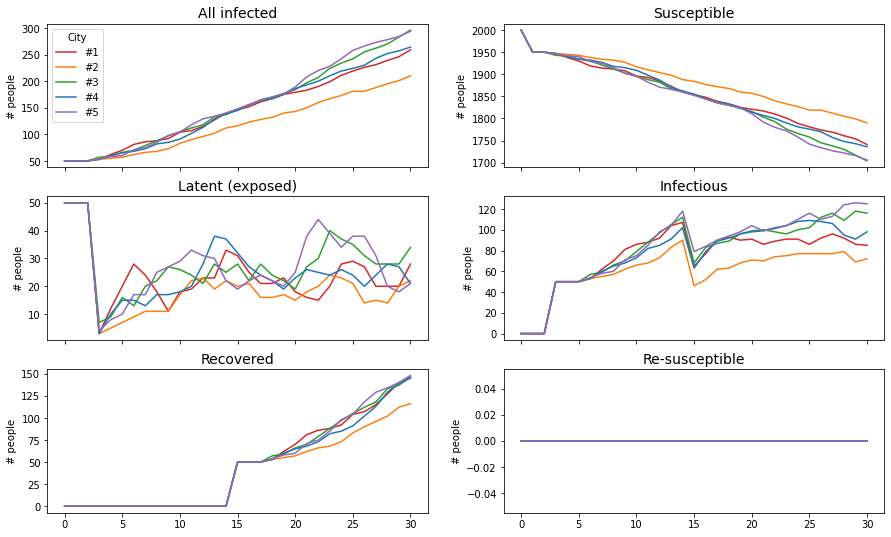

In [44]:
#@title Plotting [double-click here to show/hide code]
#print(tracker_n_infected_ALL)

tracker_names = ['All infected', 'Susceptible', 'Latent (exposed)', 'Infectious', 'Recovered', 'Re-susceptible']
trackers = [
    tracker_n_infected_ALL,
    tracker_n_infected_susceptible,
    tracker_n_infected_latent,
    tracker_n_infected_infectious,
    tracker_n_infected_recovered,
    tracker_n_infected_resusceptible,
]

'''
# Create a GoogleWidget TabBar with each of the Infection tracker names 
infections_tb = gwidgets.TabBar(tracker_names)

for i, tracker in enumerate(trackers):
  with infections_tb.output_to(i):
    for infection, cities in tracker.items():
      for city, city_count in cities.items():
        #print(f"\n{50*'*'}\n\tNumber of citizens of {city} infected with {infection}\n")
        plt.plot(city_count)
        plt.title(tracker_names[i])
        plt.show()
      # end for: adding and plotting every bin
    # end for
  # end with: plotting infections
# end for: printing the infection trackers
'''

N_ROWS = 3
N_COLS = 2
COLORS = ['tab:red', 'tab:orange', 'tab:green', 'tab:blue', 'tab:purple', 'tab:brown']

#diseases_tb = gwidgets.TabBar([disease.name() for disease in diseases])
fig, axs = plt.subplots(N_ROWS, N_COLS, figsize=(15,9), sharex=True)

# Set a tab for each disease
'''
for i in range(len(diseases)):
  # Select the tab
  with diseases_tb.output_to(i):
    # Now plot each infection tracker for all cities, with
    # one plot for each tracker, and all cities together in each plot
'''

for j, ax in enumerate(axs.flat):
  # The row and column in the plots grid for the trackers
  row = j//N_COLS
  col = j - row*N_COLS
  cities_tracker = trackers[j][disease]
  #print(cities_tracker)
  city_idx = 0
  for city, city_count in cities_tracker.items():
    #print(city)
    #print(city_count)
    #print(f"\n{50*'*'}\n\tNumber of citizens of {city} infected with {infection}\n")
    axs[row, col].plot(city_count, color=COLORS[city_idx], label=f"#{city_idx+1}")
    axs[row, col].set_title(tracker_names[j], fontsize=14)
    ax.set(ylabel='# people')
    if j == 0:
      # Add a legend to the first plot
      ax.legend(title="City")#, frameon=False)
    # Hide x labels and tick labels for top plots and y ticks for right plots.
    #ax.label_outer()
    # increase the colour pointer for the city
    city_idx += 1
  # end for: adding and plotting every bin
# end for

#  # end with: plotting infections
## end for: printing the infection trackers

# Supplementary information

## Mathematics of the model
(under construction)

<a name="contributors"></a>
# Contributors and rights
The people below have all contributed in some way to the development of this model. If you want to collaborate, please contact Victor.
* **Victor Sojo** | American Museum of Natural History, New York | vsojo@amnh.org
+ **Janina Roemer** | Ludwig-Maximilian University of Munich

We sincerely encourage you to modify this code as much as you wish. We only ask that you kindly contact us (either via email, or by making a fork/pull-request on GitHub) if you make a significant improvement, so that we can update here.

This code is released under a [CC-BY-NC-SA](https://creativecommons.org/licenses/by-nc-sa/4.0/) license.